In [6]:
!pip install ipython-autotime --quiet
%load_ext autotime

time: 136 µs (started: 2021-12-17 18:55:39 +00:00)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
import glob
import os
import gc

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

time: 4.77 ms (started: 2021-12-17 18:55:39 +00:00)


#### Connect To Drive

In [8]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data
time: 27.5 s (started: 2021-12-17 18:55:39 +00:00)


In [9]:
TRAIN_IMAGE_PATH = "/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images"
TEST_IMAGE_PATH = "/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images"
TRAIN_IMAGE_CSV_PATH = "/content/data/MyDrive/ColabNotebooks/CapstoneProject/Train CSV"
TEST_IMAGE_CSV_PATH = "/content/data/MyDrive/ColabNotebooks/CapstoneProject/Test CSV"

time: 2.05 ms (started: 2021-12-17 18:56:07 +00:00)


In [10]:
df_train_annotations = pd.read_csv('/content/data/MyDrive/ColabNotebooks/CapstoneProject/Annotations/Train Annotations.csv')
df_test_annotations = pd.read_csv('/content/data/MyDrive/ColabNotebooks/CapstoneProject/Annotations/Test Annotation.csv')

time: 2.48 s (started: 2021-12-17 18:56:07 +00:00)


In [11]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNEL = 3

time: 868 µs (started: 2021-12-17 18:56:09 +00:00)


In [12]:
df_train_annotations.head()

,Image Name,Bounding Box coordinates,Unnamed: 2,Unnamed: 3,Unnamed: 4,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


time: 31.7 ms (started: 2021-12-17 18:56:09 +00:00)


The bounding box coordinates are not clearly labelled. It could be either in (xmin, ymin, xmax, ymax) format or (x, y, width, height) format. First, I will assume that the coordinates are in (xmin, ymin, xmax, ymax) format and change the columns names accordingly.

In [13]:
def rename_columns(annotation_data):
  annotation_data.rename(columns = {'Bounding Box coordinates':'xmin'}, inplace = True)
  annotation_data.rename(columns = {'Unnamed: 2':'ymin'}, inplace = True)
  annotation_data.rename(columns = {'Unnamed: 3':'xmax'}, inplace = True)
  annotation_data.rename(columns = {'Unnamed: 4':'ymax'}, inplace = True)
  annotation_data.rename(columns = {'Image class':'image_class'}, inplace = True)
  annotation_data.rename(columns = {'Image Name':'image_name'}, inplace = True)
  return annotation_data

time: 7.19 ms (started: 2021-12-17 18:56:09 +00:00)


In [14]:
# Changing column names of train and test annotations
df_train_annotations = rename_columns(df_train_annotations)
df_test_annotations = rename_columns(df_test_annotations)

time: 3.67 ms (started: 2021-12-17 18:56:09 +00:00)


In the training set there are 196 unique classes i.e. 196 different makes of cars

In [15]:
len(df_train_annotations['image_class'].unique())

196

time: 5.9 ms (started: 2021-12-17 18:56:09 +00:00)


In [16]:
#Loading name of cars 
df_carnames = pd.read_csv("/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car names and make.csv",header=None)

time: 431 ms (started: 2021-12-17 18:56:09 +00:00)


The number of car names match the number of unique make of cars in the training annotations file

In [17]:
df_carnames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       196 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB
time: 16.9 ms (started: 2021-12-17 18:56:10 +00:00)


In [18]:
df_carnames.head()

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


time: 10.6 ms (started: 2021-12-17 18:56:10 +00:00)


In [19]:
# Method to verify the whether the bounding box coordinates are fitting correctly
def show_image_with_bounding_box(image_name):
  image_path = glob.glob(TRAIN_IMAGE_PATH+"/**/"+image_name, recursive = True)
  annotation = df_train_annotations[df_train_annotations["image_name"] == image_name]

  #Set bounding box coordinates as tuple
  start_point = (annotation.xmin, annotation.ymin) 
  end_point = (annotation.xmax, annotation.ymax)

  # Blue color in BGR 
  color = (255, 0, 0) 
    
  # Line thickness of 2 px 
  thickness = 1
  
  #read image using cv2
  image = cv2.imread(image_path[0])

  # Using cv2.rectangle() method 
  # Draw a rectangle with blue line borders of thickness of 2 px 
  image = cv2.rectangle(image, start_point, end_point, color, thickness)

  #Show the image with matplotlib
  plt.imshow(image)
  plt.show()

time: 15.8 ms (started: 2021-12-17 18:56:10 +00:00)


The below sample images confirm that the bounding box coordinates are in (xmin, ymin, xmax, ymax) format

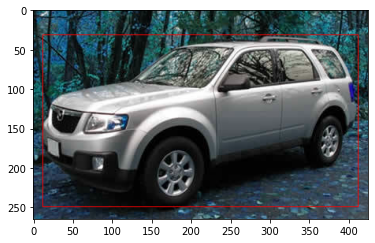

time: 43 s (started: 2021-12-17 18:56:10 +00:00)


In [20]:
# Sample image with bounding box
show_image_with_bounding_box("00499.jpg")

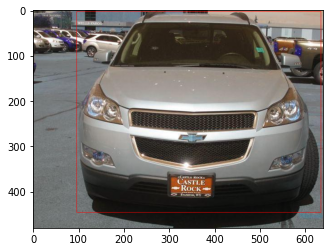

time: 1.24 s (started: 2021-12-17 18:56:53 +00:00)


In [21]:
# Sample image with bounding box
show_image_with_bounding_box("00998.jpg")

Checking whether the number of images in train and test set match against the number of annotations in train and test.

There are 8144 annotations in training set and 8041 annotations in test set.

In [22]:
print(df_train_annotations.shape)
print(df_test_annotations.shape)

(8144, 6)
(8041, 6)
time: 7.43 ms (started: 2021-12-17 18:56:54 +00:00)


Number of images in Training set matches the number of annotations i.e. 8144 and all the images in traning set are "jpg" images.

In [23]:
image_path = glob.glob(TRAIN_IMAGE_PATH+"/**/*.jpg", recursive = True)
len(image_path)

8144

time: 473 ms (started: 2021-12-17 18:56:54 +00:00)


Number of images in Test set matches the number of annotations i.e. 8041 and all the images in traning set are "jpg" images.

In [24]:
image_path = glob.glob(TEST_IMAGE_PATH+"/**/*.jpg", recursive = True)
len(image_path)

8041

time: 426 ms (started: 2021-12-17 18:56:55 +00:00)


Creating an image dataframe that contains image details

In [25]:
def createImageDF(imageSourceFolder,totalImagePerClassCap):
    dfRows=[]
    for dirname, _, filenames in os.walk(imageSourceFolder):
            limit=0
            if len(filenames) < totalImagePerClassCap or totalImagePerClassCap == 0:
                limit=len(filenames)
            else:
                limit=totalImagePerClassCap
            for i in range(0,limit):
                    processedRows=[]
                    filename=filenames[i]
                    if filename == ".DS_Store":
                      continue
                    #print('filename: ', filename)
                    processedRows.append(filename)
                    pathSplits=dirname.split('/')
                    imgPath=os.path.join(dirname, filename)
                    #print(imgPath)
                    img = image.load_img(imgPath)
                    image_width = img.width
                    image_height = img.height
                    processedRows.append(imgPath)
                    processedRows.append(pathSplits[len(pathSplits)-1])
                    processedRows.append(image_width)
                    processedRows.append(image_height)
                    dfRows.append(processedRows)
    return pd.DataFrame(dfRows, columns=["image_name","image_path","model", "image_width", "image_height"])

time: 12 ms (started: 2021-12-17 18:56:55 +00:00)


In [26]:
#df_train = createImageDF(TRAIN_IMAGE_PATH,0)

time: 553 µs (started: 2021-12-17 18:56:55 +00:00)


In [27]:
#df_train.to_csv(TRAIN_IMAGE_CSV_PATH + "/train_image.csv")

time: 535 µs (started: 2021-12-17 18:56:55 +00:00)


In [28]:
df_train = pd.read_csv(TRAIN_IMAGE_CSV_PATH + "/train_image.csv");
df_train.drop(["Unnamed: 0"], axis=1, inplace=True)
df_train.head()

,image_name,image_path,model,image_width,image_height
0,01034.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneP...,Acura RL Sedan 2012,960,347
1,03767.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneP...,Acura RL Sedan 2012,300,200
2,06839.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneP...,Acura RL Sedan 2012,300,164
3,01535.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneP...,Acura RL Sedan 2012,450,225
4,03875.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneP...,Acura RL Sedan 2012,800,528


time: 479 ms (started: 2021-12-17 18:56:55 +00:00)


In [29]:
NUMBER_OF_LABELS = len(df_train.model.unique())

time: 6.25 ms (started: 2021-12-17 18:56:55 +00:00)


In [30]:
#df_test = createImageDF(TEST_IMAGE_PATH,0)

time: 508 µs (started: 2021-12-17 18:56:56 +00:00)


In [31]:
#df_test.to_csv(TEST_IMAGE_CSV_PATH + "/test_image.csv")

time: 411 µs (started: 2021-12-17 18:56:56 +00:00)


In [32]:
pd.set_option('display.max_colwidth', 1000)
df_test = pd.read_csv(TEST_IMAGE_CSV_PATH + "/test_image.csv");
df_test.drop(["Unnamed: 0"], axis=1, inplace=True)
df_test.head()

,image_name,image_path,model,image_width,image_height
0,00130.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/00130.jpg,Acura Integra Type R 2001,800,458
1,01002.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/01002.jpg,Acura Integra Type R 2001,551,823
2,00128.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/00128.jpg,Acura Integra Type R 2001,900,600
3,01176.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/01176.jpg,Acura Integra Type R 2001,1600,1200
4,00565.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/00565.jpg,Acura Integra Type R 2001,545,380


time: 500 ms (started: 2021-12-17 18:56:56 +00:00)


In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_name    8144 non-null   object
 1   image_path    8144 non-null   object
 2   model         8144 non-null   object
 3   image_width   8144 non-null   int64 
 4   image_height  8144 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 318.2+ KB
time: 11.6 ms (started: 2021-12-17 18:56:56 +00:00)


In [34]:
df_train_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   8144 non-null   object
 1   xmin         8144 non-null   int64 
 2   ymin         8144 non-null   int64 
 3   xmax         8144 non-null   int64 
 4   ymax         8144 non-null   int64 
 5   image_class  8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB
time: 8.27 ms (started: 2021-12-17 18:56:56 +00:00)


Merging train and test dataframes with annotations dataframe

In [35]:
#Merging the annotation details of images from df_train_annotations based on image_name
df_train = pd.merge(df_train, df_train_annotations, on=['image_name'])

time: 15.1 ms (started: 2021-12-17 18:56:56 +00:00)


In [36]:
df_train.head(1)

,image_name,image_path,model,image_width,image_height,xmin,ymin,xmax,ymax,image_class
0,01034.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/01034.jpg,Acura RL Sedan 2012,960,347,115,63,817,324,2


time: 19.1 ms (started: 2021-12-17 18:56:56 +00:00)


In [37]:
df_train.head()

,image_name,image_path,model,image_width,image_height,xmin,ymin,xmax,ymax,image_class
0,01034.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/01034.jpg,Acura RL Sedan 2012,960,347,115,63,817,324,2
1,03767.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/03767.jpg,Acura RL Sedan 2012,300,200,36,40,261,174,2
2,06839.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/06839.jpg,Acura RL Sedan 2012,300,164,34,53,270,139,2
3,01535.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/01535.jpg,Acura RL Sedan 2012,450,225,8,29,444,213,2
4,03875.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/03875.jpg,Acura RL Sedan 2012,800,528,45,22,745,514,2


time: 21 ms (started: 2021-12-17 18:56:56 +00:00)


In [38]:
#Merging the annotation details of images from df_test_annotations based on image_name
df_test = pd.merge(df_test, df_test_annotations, on=['image_name'])
df_test.head()

,image_name,image_path,model,image_width,image_height,xmin,ymin,xmax,ymax,image_class
0,00130.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/00130.jpg,Acura Integra Type R 2001,800,458,27,74,774,449,6
1,01002.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/01002.jpg,Acura Integra Type R 2001,551,823,54,225,499,610,6
2,00128.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/00128.jpg,Acura Integra Type R 2001,900,600,122,149,743,455,6
3,01176.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/01176.jpg,Acura Integra Type R 2001,1600,1200,289,433,1462,904,6
4,00565.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images/Acura Integra Type R 2001/00565.jpg,Acura Integra Type R 2001,545,380,15,1,545,347,6


time: 27.1 ms (started: 2021-12-17 18:56:56 +00:00)


In [39]:
print("Train dataframe size ", len(df_train))

Train dataframe size  8144
time: 886 µs (started: 2021-12-17 18:56:56 +00:00)


In [40]:
print("Test dataframe size ", len(df_test))

Test dataframe size  8041
time: 1.07 ms (started: 2021-12-17 18:56:56 +00:00)


In [41]:
df_train.head()

,image_name,image_path,model,image_width,image_height,xmin,ymin,xmax,ymax,image_class
0,01034.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/01034.jpg,Acura RL Sedan 2012,960,347,115,63,817,324,2
1,03767.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/03767.jpg,Acura RL Sedan 2012,300,200,36,40,261,174,2
2,06839.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/06839.jpg,Acura RL Sedan 2012,300,164,34,53,270,139,2
3,01535.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/01535.jpg,Acura RL Sedan 2012,450,225,8,29,444,213,2
4,03875.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Acura RL Sedan 2012/03875.jpg,Acura RL Sedan 2012,800,528,45,22,745,514,2


time: 28.5 ms (started: 2021-12-17 18:56:56 +00:00)


## Splitting train dataframe into train and validation dataframe

In [42]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)

time: 8.61 ms (started: 2021-12-17 18:56:56 +00:00)


In [43]:
df_train.head()

,image_name,image_path,model,image_width,image_height,xmin,ymin,xmax,ymax,image_class
5642,02239.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Hyundai Veracruz SUV 2012/02239.jpg,Hyundai Veracruz SUV 2012,1024,768,55,41,969,673,133
5674,00563.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Hyundai Veloster Hatchback 2012/00563.jpg,Hyundai Veloster Hatchback 2012,900,599,9,78,899,520,130
2456,01108.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Chevrolet Corvette Convertible 2012/01108.jpg,Chevrolet Corvette Convertible 2012,480,360,12,166,472,295,55
6274,06077.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Jeep Grand Cherokee SUV 2012/06077.jpg,Jeep Grand Cherokee SUV 2012,259,194,15,4,234,172,148
6317,00343.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Jeep Liberty SUV 2012/00343.jpg,Jeep Liberty SUV 2012,800,600,63,36,760,504,147


time: 22.4 ms (started: 2021-12-17 18:56:56 +00:00)


After splitting, verifying the size of train/val/test dataframes

In [44]:
print("Train dataframe size ", len(df_train))
print("Validation dataframe size ", len(df_val))
print("Test dataframe size ", len(df_test))

Train dataframe size  6108
Validation dataframe size  2036
Test dataframe size  8041
time: 2.52 ms (started: 2021-12-17 18:56:56 +00:00)


In [45]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

time: 5.79 ms (started: 2021-12-17 18:56:56 +00:00)


#### Encoding the car models for classification

In [46]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df_train['encoded_model']= label_encoder.fit_transform(df_train['model'])
df_val['encoded_model']= label_encoder.fit_transform(df_val['model'])
df_test['encoded_model']= label_encoder.fit_transform(df_test['model'])

time: 10.7 ms (started: 2021-12-17 18:56:56 +00:00)


In [47]:
df_train.head(1)

,index,image_name,image_path,model,image_width,image_height,xmin,ymin,xmax,ymax,image_class,encoded_model
0,5642,02239.jpg,/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Hyundai Veracruz SUV 2012/02239.jpg,Hyundai Veracruz SUV 2012,1024,768,55,41,969,673,133,139


time: 21.1 ms (started: 2021-12-17 18:56:56 +00:00)


In [48]:
df1 = df_train.head(1)
df1 = df1.image_path

time: 1.2 ms (started: 2021-12-17 18:56:56 +00:00)


In [49]:
df1

0    /content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images/Hyundai Veracruz SUV 2012/02239.jpg
Name: image_path, dtype: object

time: 5.5 ms (started: 2021-12-17 18:56:56 +00:00)


## Draw bounding boxes on resized images for train/val/test just to make sure the data in dataframe is correct

In [50]:
def drawBoundingBoxesOnResizedImages(df):
  #Pickup a random image number
  img_num = np.random.randint(0, df.shape[0])
  #Read the image and draw a rectangle as per bounding box information
  img = cv2.imread(df.loc[img_num].image_path)
  img = cv2.resize(img,(224, 224))
  w = df.loc[img_num, 'image_width']
  h = df.loc[img_num, 'image_height']
  x_ratio = 224/w
  y_ratio = 224/h
  cv2.rectangle(img, 
              (int(df.loc[img_num, 'xmin']*x_ratio),int(df.loc[img_num, 'ymin']*y_ratio)),
              (int(df.loc[img_num, 'xmax']*x_ratio),int(df.loc[img_num, 'ymax']*y_ratio)), 
              (0,255,0),
              2)

  #Convert BGR format (used by opencv to RGB format used by matplotlib)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  #Draw image using matplotlib
  plt.suptitle(df.loc[img_num, 'model'])
  plt.imshow(img)
  plt.show()

time: 14 ms (started: 2021-12-17 18:56:56 +00:00)


Train dataframe

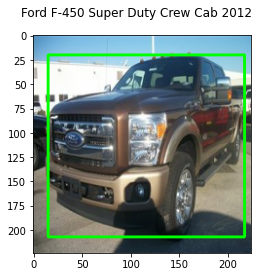

time: 777 ms (started: 2021-12-17 18:56:56 +00:00)


In [51]:
drawBoundingBoxesOnResizedImages(df_train)

Validation dataframe

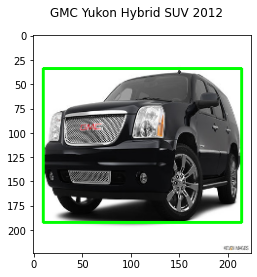

time: 778 ms (started: 2021-12-17 18:56:57 +00:00)


In [52]:
drawBoundingBoxesOnResizedImages(df_val)

Test dataframe

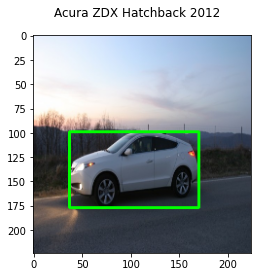

time: 782 ms (started: 2021-12-17 18:56:58 +00:00)


In [53]:
drawBoundingBoxesOnResizedImages(df_test)

In [54]:
len(df_train.encoded_model.unique())

196

time: 3.68 ms (started: 2021-12-17 18:56:59 +00:00)


## Create Batch Generators

In [73]:
def batch_generator(df, batch_size=32):
    while True:
        #Generate index numbers to be used in a batch
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)
        #Create empty array to hold images array
        batch_images = np.zeros(shape=(batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, 3))
        #Classification Labels 
        batch_labels = np.zeros(shape=(batch_size, NUMBER_OF_LABELS))
        #Regression labels - to store bounding box values
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        for i in range(batch_size):
            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'image_path'],  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
            #Convert to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            #Update batch
            batch_images[i] = img_array
            #Read image classification label & convert to one hot vector
            cl_label = df.loc[image_nums[i], 'encoded_model']
            cl_label = tf.keras.utils.to_categorical(cl_label, num_classes=NUMBER_OF_LABELS)
            batch_labels[i] = cl_label
            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'image_width']
            img_height = df.loc[image_nums[i], 'image_height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * IMAGE_WIDTH/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * IMAGE_WIDTH/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * IMAGE_HEIGHT/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * IMAGE_HEIGHT/img_height

            #Store the bounding box values of resized image
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        for i in range(batch_size):
            batch_images[i] = tf.keras.applications.resnet50.preprocess_input(batch_images[i])
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1
        batch_bboxes = batch_bboxes/IMAGE_WIDTH

        #Return batch - use yield function to make it a python generator
        yield batch_images, [batch_labels, batch_bboxes]

time: 29.4 ms (started: 2021-12-17 19:03:59 +00:00)


#### Checking the output of the batch generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 224, 224, 3)
(2, 196) (2, 4)
2
['Hyundai Elantra Sedan 2007' 'Ram C-V Cargo Van Minivan 2012']


<Figure size 720x288 with 0 Axes>

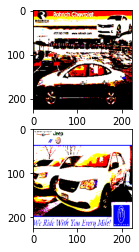

time: 1.39 s (started: 2021-12-17 19:34:23 +00:00)


In [92]:
gen = batch_generator(df_train, batch_size=2)
X, y = next(gen)
print(X.shape)
print(y[0].shape, y[1].shape)

from keras.utils.np_utils import to_categorical

encoded_labels_list = []
# label_encoder.inverse_transform(y[0][0])
for i in range(0,len(y[0])):
  y1 = int(np.argmax(y[0][i], axis=-1))
  encoded_labels_list.extend([y1])

print(len(encoded_labels_list))
print(label_encoder.inverse_transform(encoded_labels_list))

plt.figure(figsize =(10, 4))

#subplot(r,c) provide the no. of rows and columns
f, axes = plt.subplots(len(y[0]),1) 

for i in range(0,len(y[0])):
  axes[i].imshow(X[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 224, 224, 3)
(2, 196) (2, 4)
2
['Dodge Charger Sedan 2012' 'Ford Ranger SuperCab 2011']


<Figure size 720x288 with 0 Axes>

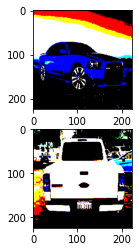

time: 1.39 s (started: 2021-12-17 19:35:38 +00:00)


In [93]:
gen = batch_generator(df_val, batch_size=2)
X, y = next(gen)
print(X.shape)
print(y[0].shape, y[1].shape)

from keras.utils.np_utils import to_categorical

encoded_labels_list = []
# label_encoder.inverse_transform(y[0][0])
for i in range(0,len(y[0])):
  y1 = int(np.argmax(y[0][i], axis=-1))
  encoded_labels_list.extend([y1])

print(len(encoded_labels_list))
print(label_encoder.inverse_transform(encoded_labels_list))

plt.figure(figsize =(10, 4))

#subplot(r,c) provide the no. of rows and columns
f, axes = plt.subplots(len(y[0]),1) 

for i in range(0,len(y[0])):
  axes[i].imshow(X[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 224, 224, 3)
(2, 196) (2, 4)
2
['smart fortwo Convertible 2012' 'Ford GT Coupe 2006']


<Figure size 720x288 with 0 Axes>

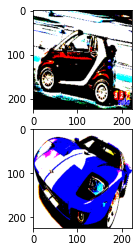

time: 1.24 s (started: 2021-12-17 19:36:02 +00:00)


In [94]:
gen = batch_generator(df_test, batch_size=2)
X, y = next(gen)
print(X.shape)
print(y[0].shape, y[1].shape)

from keras.utils.np_utils import to_categorical

encoded_labels_list = []
# label_encoder.inverse_transform(y[0][0])
for i in range(0,len(y[0])):
  y1 = int(np.argmax(y[0][i], axis=-1))
  encoded_labels_list.extend([y1])

print(len(encoded_labels_list))
print(label_encoder.inverse_transform(encoded_labels_list))

plt.figure(figsize =(10, 4))

#subplot(r,c) provide the no. of rows and columns
f, axes = plt.subplots(len(y[0]),1) 

for i in range(0,len(y[0])):
  axes[i].imshow(X[i])

## Build the Model

#### Load Pre-Trained Model

In [95]:
tf.keras.backend.clear_session()
model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, #Do not include FC layer at the end
                                       input_shape=(224, 224, 3),
                                       weights='imagenet')

115277824/115263384 [==============================] - 28s 0us/step
time: 43 s (started: 2021-12-17 19:36:28 +00:00)


In [96]:
model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

#### Un-Freeze Few layers of Pre-trained model

In [97]:
len(model.layers)

576

time: 7.08 ms (started: 2021-12-17 19:37:26 +00:00)


In [98]:
# for layer in model.layers:
#     layer.trainable = True

# # # #Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = True
#######Unfreezing all layers after layer#
for layer in model.layers[0:257]:
    layer.trainable = False
    # print(layer)

time: 22.9 ms (started: 2021-12-17 19:37:47 +00:00)


In [99]:
model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [100]:
model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'top_activation')>

time: 3 ms (started: 2021-12-17 19:37:51 +00:00)


#### Add Final layers to the model

In [104]:
#get Output layer of Pre-trained model
x1 = model.output

#Flatten the output to feed to Dense layer
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)

#Add one Dense layer
x3 = tf.keras.layers.Dense(2048, activation='relu')(x2)

#Batch Norm
x4 = tf.keras.layers.BatchNormalization()(x3)

time: 30.8 ms (started: 2021-12-17 19:40:37 +00:00)


#### Build layer for Classification Label output

In [117]:
#Classification
label_output = tf.keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax', name='class_op')(x4)

time: 14.3 ms (started: 2021-12-17 19:49:16 +00:00)


In [118]:
label_output

<KerasTensor: shape=(None, 196) dtype=float32 (created by layer 'class_op')>

time: 2.34 ms (started: 2021-12-17 19:49:20 +00:00)


#### Build layer for bounding box output

In [119]:
#Regression
bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='reg_op')(x4)

time: 11.8 ms (started: 2021-12-17 19:49:23 +00:00)


In [120]:
bbox_output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'reg_op')>

time: 3.05 ms (started: 2021-12-17 19:49:24 +00:00)


#### Finalize the model

In [121]:
#Non Sequential model as it has two different outputs
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=[label_output,bbox_output]) #Output layer added

time: 34 ms (started: 2021-12-17 19:49:25 +00:00)


In [122]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

#### Define function to calculate IoU

In [123]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = np.array(y_true, dtype=np.float32)
        y_pred = np.array(y_pred, dtype=np.float32)

        #print(y_true.shape)
        #print(y_pred.shape)
        # boxTrue
        x_boxTrue_tleft = y_true[i,0]  # numpy index selection
        y_boxTrue_tleft = y_true[i,1]
        boxTrue_width = y_true[i,2]
        boxTrue_height = y_true[i,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[i,0]
        y_boxPred_tleft = y_pred[i,1]
        boxPred_width = y_pred[i,2]
        boxPred_height = y_pred[i,3]
        area_boxPred = (boxPred_width * boxPred_height)

        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = np.array(iou, dtype=np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)



def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

time: 46.9 ms (started: 2021-12-17 19:49:33 +00:00)


In [124]:
final_model.compile(optimizer='adam', 
                    loss={'reg_op':'mse', 'class_op':'categorical_crossentropy'},
                    # loss_weights={'reg_op':20, 'class_op':196},
                    metrics={'reg_op':[IoU], 'class_op':['accuracy']})

time: 21.3 ms (started: 2021-12-17 19:49:34 +00:00)


#### Train the model

In [125]:
#Create train and test generator
batchsize = 64
train_generator = batch_generator(df_train, batch_size=batchsize)
test_generator = batch_generator(df_val, batch_size=batchsize)

time: 1.69 ms (started: 2021-12-17 19:49:49 +00:00)


In [126]:
final_model.fit(train_generator,
                epochs=5,
                steps_per_epoch= df_train.shape[0]//batchsize,validation_data=test_generator,
                validation_steps = df_val.shape[0]//batchsize)

Epoch 1/5
95/95 [==============================] - 2602s 27s/step - loss: 3.6033 - class_op_loss: 3.5252 - reg_op_loss: 0.0781 - class_op_accuracy: 0.3508 - reg_op_IoU: 0.3119 - val_loss: 3.6091 - val_class_op_loss: 3.5954 - val_reg_op_loss: 0.0137 - val_class_op_accuracy: 0.2324 - val_reg_op_IoU: 0.6624
Epoch 2/5
95/95 [==============================] - 998s 11s/step - loss: 1.3492 - class_op_loss: 1.3317 - reg_op_loss: 0.0176 - class_op_accuracy: 0.6946 - reg_op_IoU: 0.5835 - val_loss: 2.5126 - val_class_op_loss: 2.5020 - val_reg_op_loss: 0.0106 - val_class_op_accuracy: 0.4133 - val_reg_op_IoU: 0.6973
Epoch 3/5
95/95 [==============================] - 416s 4s/step - loss: 0.6810 - class_op_loss: 0.6686 - reg_op_loss: 0.0124 - class_op_accuracy: 0.8367 - reg_op_IoU: 0.6446 - val_loss: 2.1848 - val_class_op_loss: 2.1749 - val_reg_op_loss: 0.0099 - val_class_op_accuracy: 0.4929 - val_reg_op_IoU: 0.6753
Epoch 4/5
95/95 [==============================] - 216s 2s/step - loss: 0.4205 - clas

time: 1h 14min 18s (started: 2021-12-17 19:50:00 +00:00)


In [127]:
optimizerVar = tf.keras.optimizers.Adam(lr=0.0001)
final_model.compile(optimizer=optimizerVar, 
                    loss={'reg_op':'mse', 'class_op':'categorical_crossentropy'},
                    metrics={'reg_op':[IoU], 'class_op':['accuracy']})

time: 39.4 ms (started: 2021-12-17 21:04:20 +00:00)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [128]:
batchsize=16
final_model.fit(train_generator,
                epochs=10,
                initial_epoch=5,
                steps_per_epoch= df_train.shape[0]//batchsize,validation_data=test_generator,
                validation_steps = df_val.shape[0]//batchsize)

Epoch 6/10
381/381 [==============================] - 467s 1s/step - loss: 0.0523 - class_op_loss: 0.0461 - reg_op_loss: 0.0062 - class_op_accuracy: 0.9892 - reg_op_IoU: 0.7309 - val_loss: 1.3737 - val_class_op_loss: 1.3677 - val_reg_op_loss: 0.0061 - val_class_op_accuracy: 0.6976 - val_reg_op_IoU: 0.7326
Epoch 7/10
381/381 [==============================] - 421s 1s/step - loss: 0.0158 - class_op_loss: 0.0113 - reg_op_loss: 0.0045 - class_op_accuracy: 0.9981 - reg_op_IoU: 0.7598 - val_loss: 1.3068 - val_class_op_loss: 1.3013 - val_reg_op_loss: 0.0054 - val_class_op_accuracy: 0.7111 - val_reg_op_IoU: 0.7474
Epoch 8/10
381/381 [==============================] - 417s 1s/step - loss: 0.0152 - class_op_loss: 0.0116 - reg_op_loss: 0.0036 - class_op_accuracy: 0.9978 - reg_op_IoU: 0.7814 - val_loss: 1.2743 - val_class_op_loss: 1.2693 - val_reg_op_loss: 0.0049 - val_class_op_accuracy: 0.7169 - val_reg_op_IoU: 0.7582
Epoch 9/10
381/381 [==============================] - 424s 1s/step - loss: 0.01

time: 35min 52s (started: 2021-12-17 21:04:20 +00:00)


In [129]:
final_model.save('/content/data/MyDrive/ColabNotebooks/CapstoneProject/Models/Cars_196_dataset_localization.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


time: 5 s (started: 2021-12-17 21:40:13 +00:00)


In [131]:
#Create a dictionary to hold label and corresponding class name
num_classes_test = df_test['encoded_model'].unique()
label_class_dict = dict(zip(df_test['encoded_model'], df_test['model']))
print(len(num_classes_test))

196
time: 7.32 ms (started: 2021-12-17 21:42:27 +00:00)


#### Model Prediction

In [134]:
def predict_and_draw(image_num, df):

    #Load image
    img = tf.keras.preprocessing.image.load_img(df.loc[image_num, 'image_path'])
    w, h = img.size

    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)

    #3. Normalize image data
    input_array = tf.keras.applications.resnet50.preprocess_input(input_array)

    #Prediction
    pred = final_model.predict(input_array)
    #Get classification and regression predictions
    label_pred, bbox_pred = pred[0][0], pred[1][0]
    #Get Label with highest probability
    pred_class = label_class_dict[np.argmax(label_pred)]

    #Read actual label and bounding box
    act_class = df.loc[image_num, 'encoded_model']
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]

    print('Real Label :', act_class, '\nPredicted Label: ', pred_class)
    
    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'image_path'])
    
    #Draw actual bounding box - Red
    img = cv2.rectangle(img, (xmin, ymin), 
                        (xmax, ymax), (0,0,255), 3)
    
    #Draw predicted bounding box -  Green
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 3
                        )

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

time: 89.9 ms (started: 2021-12-17 21:44:35 +00:00)


Real Label : 89 
Predicted Label:  Dodge Dakota Crew Cab 2010


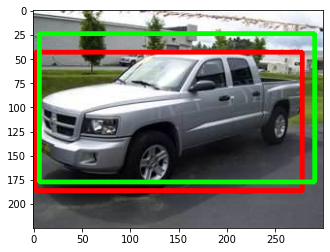

time: 709 ms (started: 2021-12-17 21:45:42 +00:00)


In [137]:
#Predict on Test Dataset
image_num = np.random.randint(0, df_test.shape[0])
predict_and_draw(image_num, df_test)